In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2 as cv

In [43]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
DATA_FOLDER = '/kaggle/input/deep-fake-detection-cropped-dataset'
FAKE_FOLDER = 'DFDC_Dataset/Fake'
REAL_FOLDER = 'DFDC_Dataset/Real'

print(f"Fake samples: {len(os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER)))}")
print(f"Real samples: {len(os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER)))}")

Fake samples: 1566
Real samples: 1727


In [4]:
fake_list = list(os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER)))
ext_dict = []
for file in fake_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4']


In [5]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in fake_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 1566


In [6]:
real_list = list(os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER)))
ext_dict = []
for file in real_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")      

Extensions: ['mp4']


In [7]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in real_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 1727


In [8]:
import shutil
from sklearn.model_selection import train_test_split

In [10]:
real_path = '/kaggle/working/real'
fake_path = '/kaggle/working/fake'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

os.makedirs(f"{train_dir}/real", exist_ok=True)
os.makedirs(f"{train_dir}/fake", exist_ok=True)
os.makedirs(f"{test_dir}/real", exist_ok=True)
os.makedirs(f"{test_dir}/fake", exist_ok=True)

In [16]:
fake_videos = os.listdir(os.path.join(DATA_FOLDER, FAKE_FOLDER))
real_videos = os.listdir(os.path.join(DATA_FOLDER, REAL_FOLDER))

In [17]:
real_train, real_test = train_test_split(real_videos, test_size=0.2, random_state=42)
fake_train, fake_test = train_test_split(fake_videos, test_size=0.2, random_state=42)

In [21]:
def copy_files(file_list, source_dir, dest_dir):
    for file in file_list:
        shutil.copy(os.path.join(source_dir, file), os.path.join(dest_dir, file))

In [22]:
copy_files(real_train, os.path.join(DATA_FOLDER, REAL_FOLDER), f"{train_dir}/real")
copy_files(real_test, os.path.join(DATA_FOLDER, REAL_FOLDER), f"{test_dir}/real")

copy_files(fake_train, os.path.join(DATA_FOLDER, FAKE_FOLDER), f"{train_dir}/fake")
copy_files(fake_test, os.path.join(DATA_FOLDER, FAKE_FOLDER), f"{test_dir}/fake")

print("Train-test split completed.")

Train-test split completed.


In [25]:
TRAIN_FAKE_FOLDER = '/kaggle/working/train/fake'
TRAIN_REAL_FOLDER = '/kaggle/working/train/real'
TEST_FAKE_FOLDER = '/kaggle/working/test/fake'
TEST_REAL_FOLDER = '/kaggle/working/test/real'

print(f"Training Fake samples: {len(os.listdir(TRAIN_FAKE_FOLDER))}")
print(f"Training Real samples: {len(os.listdir(TRAIN_REAL_FOLDER))}")
print(f"Testing Fake samples: {len(os.listdir(TEST_FAKE_FOLDER))}")
print(f"Testing Real samples: {len(os.listdir(TEST_REAL_FOLDER))}")

Training Fake samples: 1252
Training Real samples: 1381
Testing Fake samples: 314
Testing Real samples: 346


In [26]:
import math
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

In [47]:
def extract_frames(video_path, output_folder, num_frames=3):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, max(total_frames - 1, 0), num_frames, dtype=int)
    
    os.makedirs(output_folder, exist_ok=True)
    current_frame = 0
    saved_frame = 0
    ret = True
    frames_dict = {}  
    while ret and saved_frame < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame in indices:
            frame_path = os.path.join(output_folder, f"frame_{saved_frame}.jpg")
            cv.imwrite(frame_path, frame)
            saved_frame += 1
        current_frame += 1
    cap.release()

In [33]:
BASE_DATA_DIR = '/kaggle/working'
VIDEO_ROOT = BASE_DATA_DIR  
VIDEO_DIRS = {
    'train/real': os.path.join(VIDEO_ROOT, 'train/real'),
    'train/fake': os.path.join(VIDEO_ROOT, 'train/fake'),
    'test/real': os.path.join(VIDEO_ROOT, 'test/real'),
    'test/fake': os.path.join(VIDEO_ROOT, 'test/fake')
}

In [34]:
VIDEO_DIRS

{'train/real': '/kaggle/working/train/real',
 'train/fake': '/kaggle/working/train/fake',
 'test/real': '/kaggle/working/test/real',
 'test/fake': '/kaggle/working/test/fake'}

In [35]:
EXTRACTED_ROOT = os.path.join(BASE_DATA_DIR, 'extracted_seq')
for subset in ['train', 'test']:
    for label in ['real', 'fake']:
        os.makedirs(os.path.join(EXTRACTED_ROOT, subset, label), exist_ok=True)

In [48]:
for key, folder in VIDEO_DIRS.items():
    subset, label = key.split('/')
    video_files = os.listdir(folder)
    print(f"Extracting frames for {subset}/{label} ...")
    for video_file in video_files:
        video_path = os.path.join(folder, video_file)
        video_name = os.path.splitext(video_file)[0]
        output_folder = os.path.join(EXTRACTED_ROOT, subset, label, video_name)
        extract_frames(video_path, output_folder, num_frames=3)
print("Frame extraction completed.")

Extracting frames for train/real ...
Extracting frames for train/fake ...
Extracting frames for test/real ...
Extracting frames for test/fake ...
Frame extraction completed.


In [49]:
print(f"Extracted Sequence Train Real Size: {len(os.listdir('/kaggle/working/extracted_seq/train/real'))}")
print(f"Extracted Sequence Train Fake Size: {len(os.listdir('/kaggle/working/extracted_seq/train/fake'))}")
print(f"Extracted Sequence Test Rea; Size: {len(os.listdir('/kaggle/working/extracted_seq/test/real'))}")
print(f"Extracted Sequence Test Fake Size: {len(os.listdir('/kaggle/working/extracted_seq/test/fake'))}")

Extracted Sequence Train Real Size: 1381
Extracted Sequence Train Fake Size: 1252
Extracted Sequence Test Rea; Size: 346
Extracted Sequence Test Fake Size: 314


In [50]:
class VideoSequenceGenerator(Sequence):
    def __init__(self, root_dir, subset, batch_size=8, num_frames=3, target_size=(224, 224), shuffle=True):
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.target_size = target_size
        self.shuffle = shuffle
        self.samples = []
        
        for label_idx, label in enumerate(['real', 'fake']):
            label_folder = os.path.join(root_dir, subset, label)
            video_names = os.listdir(label_folder)
            for video_name in video_names:
                video_seq_path = os.path.join(label_folder, video_name)
                self.samples.append((video_seq_path, label_idx))
                
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.samples) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)
    
    def __getitem__(self, idx):
        batch_samples = self.samples[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_data = []
        batch_labels = []
        for video_seq_path, label in batch_samples:
            frame_files = sorted([os.path.join(video_seq_path, f) 
                                  for f in os.listdir(video_seq_path) if f.endswith('.jpg')])
            if len(frame_files) < self.num_frames:
                while len(frame_files) < self.num_frames:
                    frame_files.append(frame_files[-1])
            elif len(frame_files) > self.num_frames:
                frame_files = frame_files[:self.num_frames]
            frames = []
            for frame_file in frame_files:
                img = cv.imread(frame_file)
                img = cv.resize(img, self.target_size)
                img = img.astype('float32') / 255.0
                frames.append(img)
            video_array = np.array(frames)
            batch_data.append(video_array)
            batch_labels.append(label)
        return np.array(batch_data), np.array(batch_labels)

In [51]:
BATCH_SIZE = 8
NUM_FRAMES = 3
TARGET_SIZE = (224, 224)

train_gen = VideoSequenceGenerator(EXTRACTED_ROOT, subset='train', batch_size=BATCH_SIZE, 
                                   num_frames=NUM_FRAMES, target_size=TARGET_SIZE, shuffle=True)
test_gen = VideoSequenceGenerator(EXTRACTED_ROOT, subset='test', batch_size=BATCH_SIZE, 
                                  num_frames=NUM_FRAMES, target_size=TARGET_SIZE, shuffle=False)

In [55]:
input_shape = (NUM_FRAMES, TARGET_SIZE[0], TARGET_SIZE[1], 3)
video_input = Input(shape=input_shape)

In [56]:
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
cnn_base.trainable = False

td_cnn = TimeDistributed(cnn_base)(video_input)
td_pool = TimeDistributed(GlobalAveragePooling2D())(td_cnn)

lstm_out = LSTM(64, return_sequences=False)(td_pool)
dense_out = Dense(64, activation='relu')(lstm_out)
final_out = Dense(1, activation='sigmoid')(dense_out)

model = Model(inputs=video_input, outputs=final_out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 3, 224, 224, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 7, 7, 1280)       │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         344,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
EPOCHS = 10
history = model.fit(train_gen, epochs=EPOCHS, validation_data=test_gen)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


330/330 ━━━━━━━━━━━━━━━━━━━━ 205s 579ms/step - accuracy: 0.6070 - loss: 0.6623 - val_accuracy: 0.7121 - val_loss: 0.5709
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 182s 520ms/step - accuracy: 0.7081 - loss: 0.5634 - val_accuracy: 0.7273 - val_loss: 0.5247
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 206s 533ms/step - accuracy: 0.7602 - loss: 0.4996 - val_accuracy: 0.7621 - val_loss: 0.5046
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 206s 546ms/step - accuracy: 0.8057 - loss: 0.4309 - val_accuracy: 0.6742 - val_loss: 0.7271
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 176s 534ms/step - accuracy: 0.8071 - loss: 0.4015 - val_accuracy: 0.7652 - val_loss: 0.5094
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 175s 531ms/step - accuracy: 0.8549 - loss: 0.3393 - val_accuracy: 0.7561 - val_loss: 0.5240
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 204s 536ms/step - accuracy: 0.8726 - loss: 0.2932 - val_accuracy: 0.7879 - val_loss: 0.4833
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 179s 541ms/step - accuracy: 0.8920 - loss: 0.24

In [58]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 429ms/step - accuracy: 0.7863 - loss: 0.5081
Test Accuracy: 79.70%


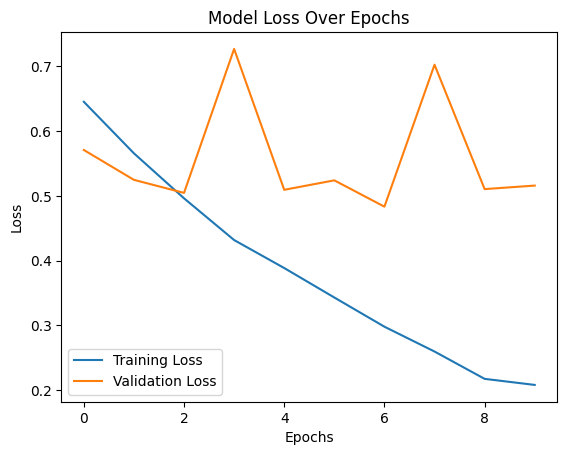

In [59]:
  plt.plot(history.history['loss'], label='Training Loss')
  if 'val_loss' in history.history:
      plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

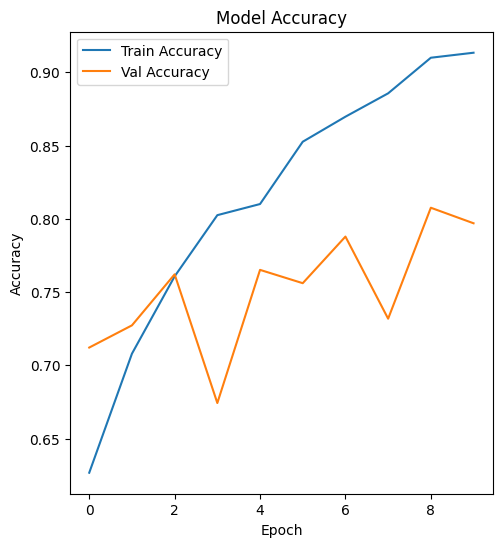

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

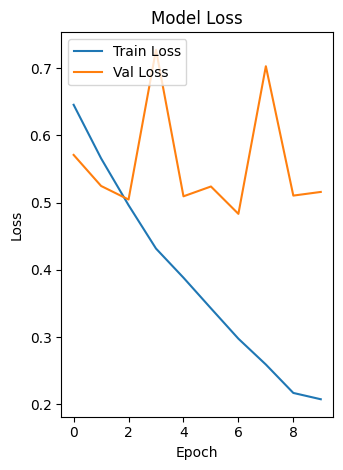

In [63]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

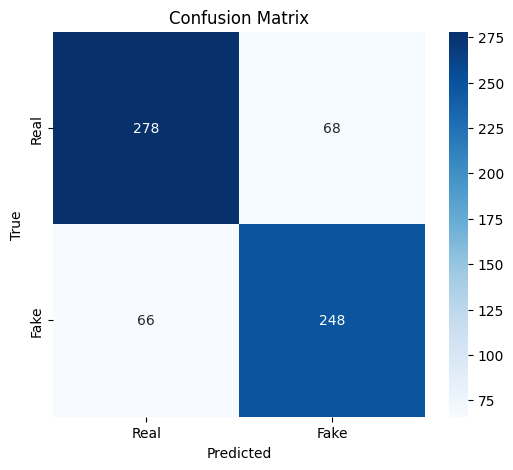

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [68]:
model.save('my_model.h5')